In [1]:
import torch
import torch.nn as nn

# Add the parent directory of 'ml' to sys.path
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from torch.utils.data import DataLoader, TensorDataset
from ml.models.multi_step_lstm import MultiStepLSTM
from ml.utils.data_utils import prepare_dataset
from argparse import Namespace
import numpy as np

In [ ]:
# Testing the prepare_dataset function with a sample configuration

args = Namespace(
    data_path='../dataset/full_dataset.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True
)

X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train targets shape: {y_train.shape}, Test targets shape: {y_test.shape}")
print(f"Train IDs shape: {id_train.shape}, Test IDs shape: {id_test.shape}")


Train shape: (21596, 10, 6), Test shape: (5399, 10, 6)
Train targets shape: (21596, 6, 5), Test targets shape: (5399, 6, 5)
Train IDs shape: (21596,), Test IDs shape: (5399,)


## Process data

In [4]:
## Sample Configuration

args = Namespace(
    data_path='../dataset/full_dataset.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    epochs=10,
    batch_size=64,
    lr=0.001,
    hidden_size=128,
    num_layers=1,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [5]:
# Prepare Data
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

In [6]:
train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), batch_size=args.batch_size)

## Model Train

In [7]:
input_dim = X_train.shape[2]
output_dim = y_train.shape[2]
model = MultiStepLSTM(input_size=input_dim, hidden_size=args.hidden_size, num_layers=args.num_layers,
                      output_size=output_dim, forecast_steps=args.forecast_steps).to(args.device)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = nn.MSELoss()

In [9]:
for epoch in range(args.epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(args.device), yb.to(args.device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[{epoch+1}/{args.epochs}] Train Loss: {total_loss/len(train_loader):.4f}")

[1/10] Train Loss: 0.0105
[2/10] Train Loss: 0.0104
[3/10] Train Loss: 0.0103
[4/10] Train Loss: 0.0103
[5/10] Train Loss: 0.0102
[6/10] Train Loss: 0.0101
[7/10] Train Loss: 0.0101
[8/10] Train Loss: 0.0100
[9/10] Train Loss: 0.0100
[10/10] Train Loss: 0.0099


In [15]:
# Save model
torch.save(model.state_dict(), "multi_step_lstm.pt")

## Evaluation

In [10]:
import torch
from ml.models.multi_step_lstm import MultiStepLSTM
from ml.utils.data_utils import prepare_dataset
from argparse import Namespace
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [11]:
args = Namespace(
    data_path='../dataset/full_dataset.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    hidden_size=128,
    num_layers=1,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [12]:
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)


In [13]:
input_dim = X_test.shape[2]
output_dim = y_test.shape[2]
model = MultiStepLSTM(input_size=input_dim, hidden_size=args.hidden_size, num_layers=args.num_layers,
                      output_size=output_dim, forecast_steps=args.forecast_steps).to(args.device)


In [16]:
model.load_state_dict(torch.load("multi_step_lstm.pt"))
model.eval()

MultiStepLSTM(
  (lstm): LSTM(6, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=30, bias=True)
)

In [17]:
with torch.no_grad():
    preds = model(torch.Tensor(X_test).to(args.device)).cpu().numpy()
    y_true = y_test

    # Reshape for evaluation: [samples * steps, targets]
    preds_flat = preds.reshape(-1, preds.shape[-1])
    y_true_flat = y_true.reshape(-1, y_true.shape[-1])

    for i, var in enumerate(args.targets):
        rmse = mean_squared_error(y_true_flat[:, i], preds_flat[:, i], squared=False)
        mae = mean_absolute_error(y_true_flat[:, i], preds_flat[:, i])
        print(f"{var}: RMSE = {rmse:.4f}, MAE = {mae:.4f}")

rnti_count: RMSE = 0.2876, MAE = 0.2532
rb_down: RMSE = 0.1787, MAE = 0.1176
rb_up: RMSE = 0.1948, MAE = 0.1231
down: RMSE = 0.1986, MAE = 0.1476
up: RMSE = 0.1814, MAE = 0.1014


c:\Users\Amir\anaconda3\envs\ua\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Amir\anaconda3\envs\ua\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Amir\anaconda3\envs\ua\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Amir\anaconda3\envs\ua\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root 

## Visualization

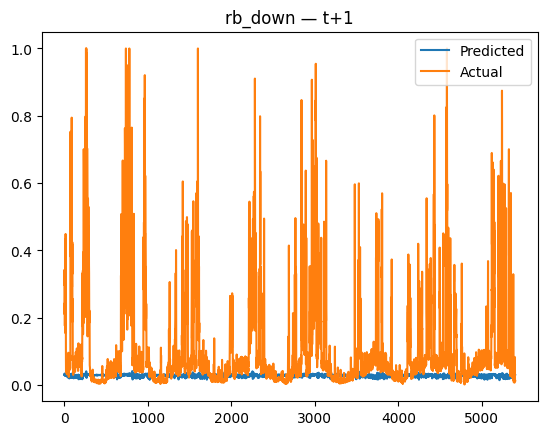

In [18]:
import matplotlib.pyplot as plt

step = 0  # forecast horizon: t+1, t+2, ..., t+5
target_idx = 1  # e.g., rb_down

plt.plot(preds[:, step, target_idx], label="Predicted")
plt.plot(y_test[:, step, target_idx], label="Actual")
plt.title(f"{args.targets[target_idx]} — t+{step+1}")
plt.legend()
plt.show()


### Visualization 1: Plot All 6 Time Steps in Separate Subplots `rb_down`

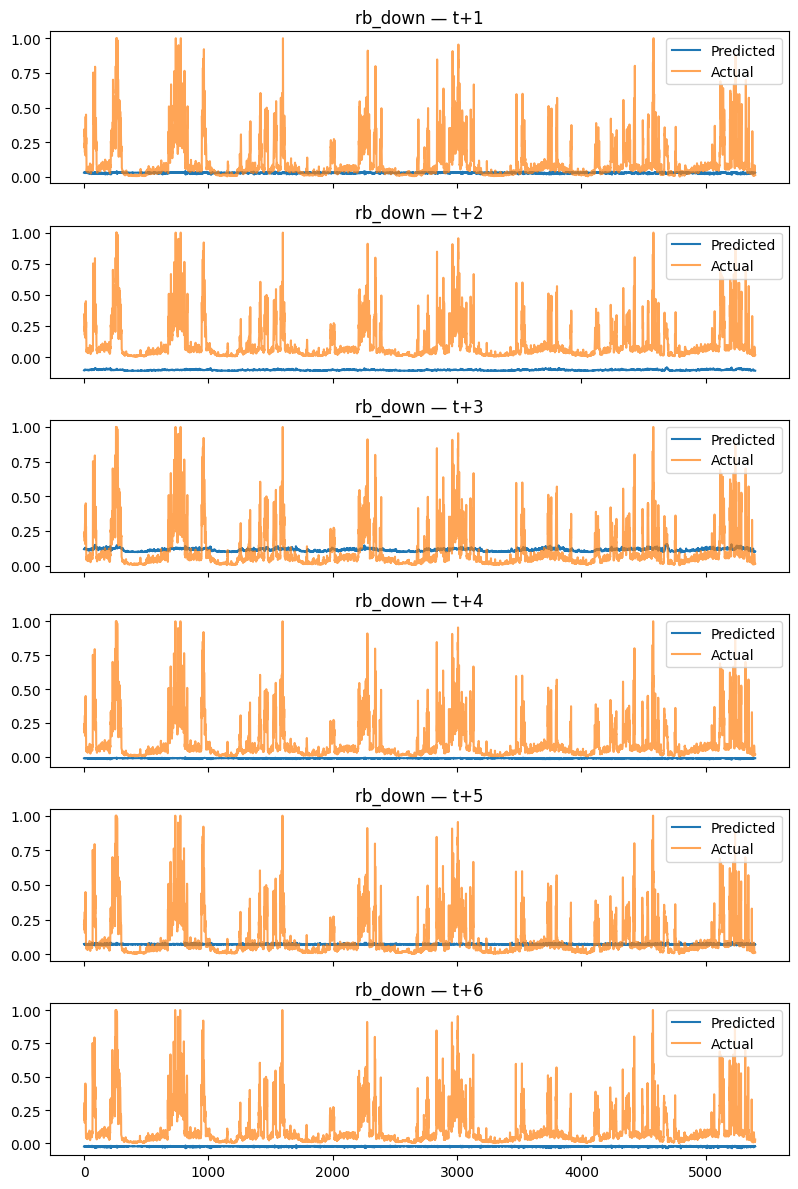

In [20]:
import matplotlib.pyplot as plt

target_idx = 1  # 'rb_down'

fig, axs = plt.subplots(6, 1, figsize=(8, 12), sharex=True)
for step in range(6):  # t+1 to t+6
    axs[step].plot(preds[:, step, target_idx], label="Predicted")
    axs[step].plot(y_test[:, step, target_idx], label="Actual", alpha=0.7)
    axs[step].set_title(f"{args.targets[target_idx]} — t+{step+1}")
    axs[step].legend()

plt.tight_layout()
plt.show()


### Visualization 2: Pick 1 Sample & Plot All Steps `rb_down`

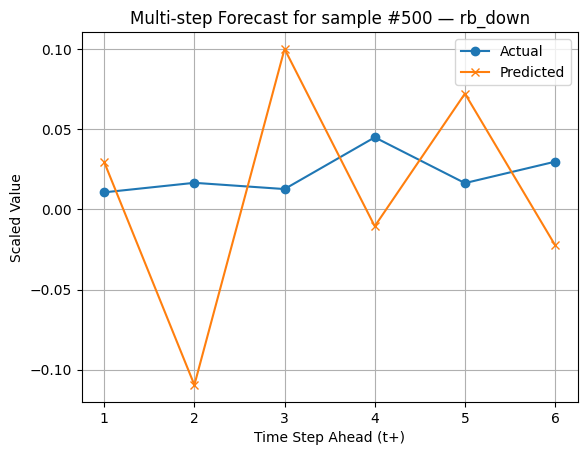

In [21]:
sample_idx = 500
target_idx = 1  # 'rb_down'

plt.plot(range(1, 7), y_test[sample_idx, :, target_idx], label="Actual", marker='o')
plt.plot(range(1, 7), preds[sample_idx, :, target_idx], label="Predicted", marker='x')
plt.title(f"Multi-step Forecast for sample #{sample_idx} — {args.targets[target_idx]}")
plt.xlabel("Time Step Ahead (t+)")
plt.ylabel("Scaled Value")
plt.xticks(range(1, 7))
plt.legend()
plt.grid(True)
plt.show()


### Visualization 1: Plot All 6 Time Steps in Separate Subplots `down` Traffic

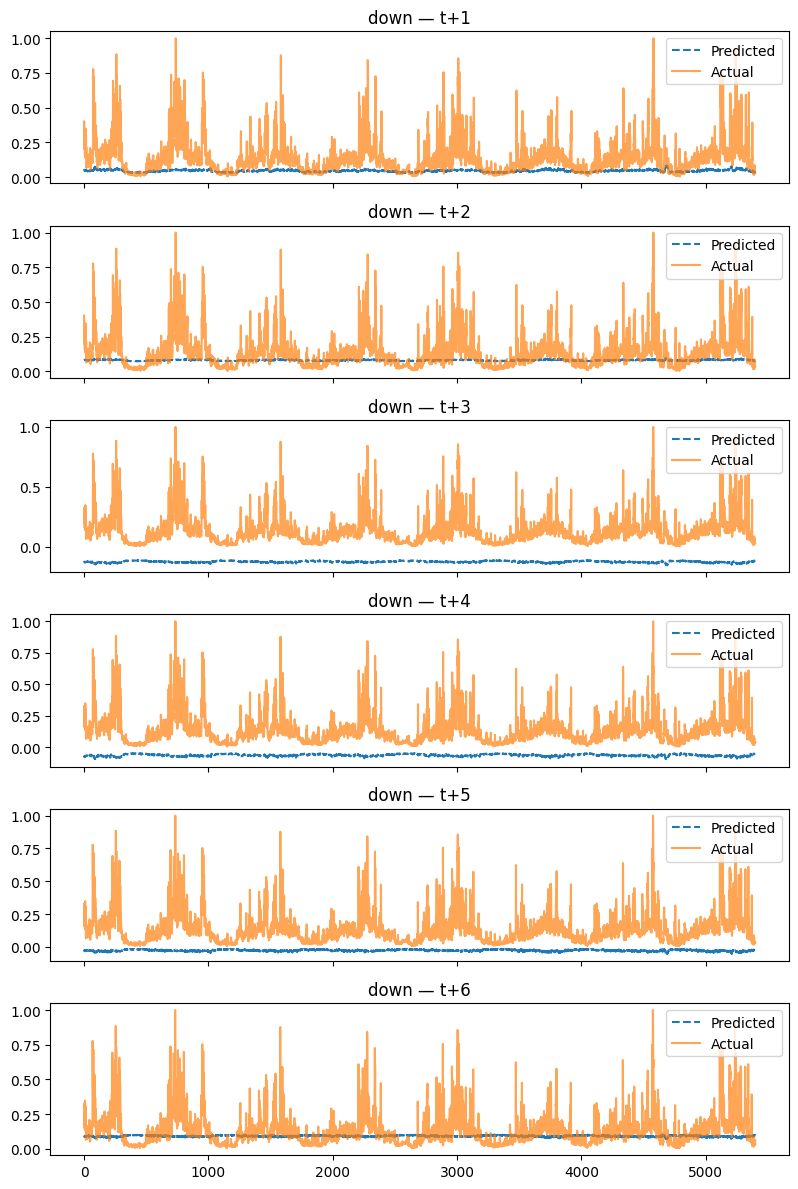

In [22]:
import matplotlib.pyplot as plt

target_idx = 3  # 'down'

fig, axs = plt.subplots(6, 1, figsize=(8, 12), sharex=True)
for step in range(6):  # t+1 to t+6
    axs[step].plot(preds[:, step, target_idx], label="Predicted", linestyle='--')
    axs[step].plot(y_test[:, step, target_idx], label="Actual", alpha=0.7)
    axs[step].set_title(f"{args.targets[target_idx]} — t+{step+1}")
    axs[step].legend()

plt.tight_layout()
plt.show()


### Visualization 2: Pick 1 Sample & Plot All Steps `down` Traffic

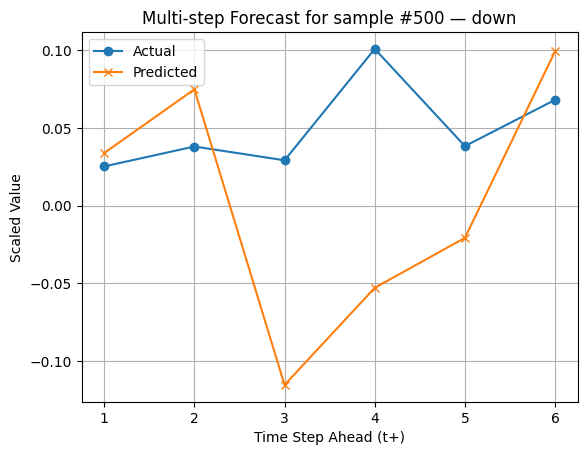

In [23]:
import matplotlib.pyplot as plt

sample_idx = 500  # pick any test sample
target_idx = 3  # 'down'

plt.plot(range(1, 7), y_test[sample_idx, :, target_idx], label="Actual", marker='o')
plt.plot(range(1, 7), preds[sample_idx, :, target_idx], label="Predicted", marker='x')
plt.title(f"Multi-step Forecast for sample #{sample_idx} — {args.targets[target_idx]}")
plt.xlabel("Time Step Ahead (t+)")
plt.ylabel("Scaled Value")
plt.xticks(range(1, 7))
plt.legend()
plt.grid(True)
plt.show()
